<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">Trabajo de fin de máster</p>
<p style="margin: 0; text-align:right;">Máster Universitario en Ciencia de Datos</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
<p style="margin: 0; text-align:right;">Azucena González Muiño</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# Construcción del modelo

En este *notebook* se realiza la construcción del modelo de predicción de actuaciones policiales de detención y cacheo de personas y/o vehículos. El objetivo es obtener un algoritmo que permita identificar qué actuaciones son más probables que finalicen con resultado positivo, es decir, con indicios de delito que requieren de una actuación policial o judicial posterior.   

El proceso de construcción se ha estructurado en los siguientes apartados:
* Definición de funciones y variables globales
* Carga de los datos necesarios
* Selección, codificación y transformación de características empleando un modelo *baseline*
* Creación y evaluación de varios modelos basados en diferentes algoritmos
* Selección del mejor modelo considerando su desempeño, tiempo de entrenamiento y nivel de explicabilidad

In [1]:
# Manipulación de datos
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

# Construcción y evaluación de modelos
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from lightgbm import LGBMClassifier

# Captura de tiempos y tratamiento de fechas
from timeit import default_timer as timer
from datetime import datetime

# Serialización de objetos
import pickle

# Generación de gráficas
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz
%matplotlib inline

## 0. Definición de funciones

Este apartado recoge varias funciones y constantes o variables globales que se emplean en las siguientes secciones.

In [2]:
# Modificación de opciones por defecto
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.4f}'.format

# Se ignoran los mensajes de aviso
from warnings import filterwarnings
filterwarnings('ignore')

# Etiquetas de clase
labels = ['False', 'True']

# Nombre de la variable objetivo
target = 'Further-action'

# Semilla para la reproducibilidad de resultados
seed = 22

# Función que codifica las variables del dataset según su tipo y divide los datos en los conjuntos de
# entrenamiento, validación y prueba
def prepare_inputs(data, target):
    for f in data.columns:
        # Se aplica one hot encoding a las variables de tipo 'object' y a las categóricas sin ordenación
        if (data[f].dtypes.name == 'object') or (data[f].dtypes.name == 'category' and not data[f].cat.ordered):
            data = pd.get_dummies(data, columns=[f], drop_first=False)
        
        # Los atributos con ordenación se codifican con OrdinalEncoder respetando su prelación
        elif (data[f].dtypes.name == 'category' and data[f].cat.ordered):
            encoder = OrdinalEncoder(categories=[data[f].cat.categories.values], dtype=np.int64)
            tmp = encoder.fit_transform(data[[f]])
            data[f] = encoder.fit_transform(data[[f]])

    # Se realiza la partición de los datos para el conjunto de training y el de test
    X_train, X_test, y_train, y_test = train_test_split(data.drop(target, axis=1), 
                                                        data[target], test_size=0.3, shuffle=False)

    # Se realiza una la división en el conjunto reservado para el entrenamiento entre training y validation
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, shuffle=False)

    return X_train, X_val, X_test, y_train, y_val, y_test

# Función que codifica las variables del dataset según su tipo empleando mean encoding para las categóricas
# y divide los datos en los conjuntos de entrenamiento, validación y prueba
def prepare_inputs_mean_enc(data, target):
    # Se obtiene el conjunto de entrenamiento para calcular el mean encoding sobre él
    X_train, _, y_train, _ = train_test_split(data, data[target], test_size=0.3, shuffle=False)
    X_train, _, _, _ = train_test_split(X_train, y_train, test_size=0.3, shuffle=False)
    
    for f in data.columns:
        # Se aplica mean encoding a las variables de tipo 'object' y a las categóricas sin ordenación
        if (data[f].dtypes.name == 'object') or (data[f].dtypes.name == 'category' and not data[f].cat.ordered):
            mean_encode = X_train.groupby([f])[target].mean().to_dict()
            data[f] = data[f].map(mean_encode)
        
        # Los atributos con ordenación se codifican respetando su prelación con OrdinalEncoder
        elif (data[f].dtypes.name == 'category' and data[f].cat.ordered):
            encoder = OrdinalEncoder(categories=[data[f].cat.categories.values], dtype=np.int64)
            tmp = encoder.fit_transform(data[[f]])
            data[f] = encoder.fit_transform(data[[f]])

    # Se realiza la partición de los datos para el conjunto de training y el de test
    X_train, X_test, y_train, y_test = train_test_split(data.drop(target, axis=1), 
                                                        data[target], test_size=0.3, shuffle=False)

    # Se realiza una nueva división en el conjunto reservado para el entrenamiento: training y validation
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, shuffle=False)

    return X_train, X_val, X_test, y_train, y_val, y_test

# Función que reescala las variables numéricas
def scale_inputs(X_train, X_val, X_test):
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    return X_train, X_val, X_test

# Función para seleccionar las variables derivadas del one hot encoding: cols contiene los nombres
# de las columnas tras las transformaciones y features los nombres originales
def get_features(cols, features):
    selected_cols = []
    for col in cols:
         if col.startswith(tuple(features)):
                selected_cols.append(col)
    return selected_cols

# Función que muestra gráficamente la matriz de confusión recibida como entrada indicando en
# cada celda el número de registros y el porcentaje que representan sobre el total
def conf_matrix_plot(conf_matrix, title='Matriz de confusión', labels=None):
    # Se convierte la matriz a dataframe
    conf_matrix_df = pd.DataFrame(conf_matrix, columns=labels, index=labels)

    # Se generan los textos a mostrar: nombres, total de registros y porcentaje
    # sobre el total
    group_names = ['TN','FP','FN','TP']
    group_counts = ['{0:.0f}'.format(value) for value in conf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
    ext_labels = [f'{l1}\n{l2}\n{l3}' for l1, l2, l3 in zip(group_names, group_counts, group_percentages)]
    ext_labels = np.asarray(ext_labels).reshape(2, 2)
    
    # Se crea un heatmap con la matriz de confusión
    sns.heatmap(conf_matrix_df, annot=ext_labels, fmt='', cmap='Blues', linewidths=2, cbar_kws={"shrink": .8})
    plt.title(title, fontsize=14)
    plt.ylabel('Valores reales', fontsize=12)
    plt.xlabel('Predicciones', fontsize=12)
    plt.yticks(rotation=0)
    
    return plt

## 1. Carga del conjunto de datos

Se procede a realizar la carga del fichero preparado previamente y que contiene los datos relativos a las actuaciones policiales de tipo "detención y registro" realizadas en Londres durante el periodo de abril de 2017 a febrero de 2021.

In [3]:
# Carga de datos policiales
london_data = pd.read_csv('./datasets/preproc-stop-and-search.csv', parse_dates=['Date'])

# Se muestra la dimensión del dataset, sus columnas y tipos de datos
print('Número de filas totales:', london_data.shape[0])
print('Número de atributos:', london_data.shape[1])
print(london_data.dtypes)

Número de filas totales: 785721
Número de atributos: 21
Type                         object
Date                 datetime64[ns]
Latitude                    float64
Longitude                   float64
Gender                       object
Age-range                    object
Self-ethnicity               object
Officer-ethnicity            object
Legislation                  object
Object                       object
Outcome                      object
Source                       object
Address                      object
Borough                      object
Year-month                   object
Location                       bool
Further-action                 bool
Short-ethnicity              object
Day                           int64
Hour                          int64
Day-of-week                  object
dtype: object


In [4]:
# Se muestra un resumen con las principales características de las variables
london_data.astype('object').describe().transpose()

,count,unique,top,freq
Type,785721,3,Person search,589746
Date,785721,400591,2018-08-27 14:00:00,68
Latitude,"785,721.0","32,954.0",51.3784,"3,365.0"
Longitude,"785,721.0","34,090.0",-0.1027,"3,365.0"
Gender,785721,4,Male,722070
Age-range,785721,6,18-24,275199
Self-ethnicity,785721,17,Other - Not stated,164274
Officer-ethnicity,785721,5,Black,307525
Legislation,785721,5,Misuse of Drugs Act 1971,479183
Object,785721,14,Controlled drugs,479107


In [5]:
# Se comprueba que no hay valores perdidos
print('Valores perdidos en el dataset:', london_data.isnull().sum().sum())

Valores perdidos en el dataset: 0


A continuación se generan dos nuevas variables con información sobre el año y el mes, se indica qué variables son categóricas con orden y se reagrupan algunos de los registros de la variable "Object", dado que el número de posibles valores es elevado y algunas de las categorías son residuales.

In [6]:
# Se incorporan variables para el mes y año
london_data['Month'] = london_data['Date'].dt.month
london_data['Year'] = london_data['Date'].dt.year

# Se marca la variable 'Age-range' como categoría con orden entre sus elementos
age_range_type = CategoricalDtype(categories=['Under 10', '10-17', '18-24', '25-34', 'Over 34', 'Unknown'], 
                                  ordered=True)
london_data['Age-range'] = london_data['Age-range'].astype(age_range_type)

# Se genera una variable a partir de 'Day-of-week' como categoría con orden
dow_type = CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
                            ordered=True)
london_data['Dow'] = london_data['Day-of-week'].astype(dow_type)

# Información básica de la variable "Object"
print('Número de valores diferentes:', len(pd.unique(london_data['Object'])))
print(london_data['Object'].value_counts())

Número de valores diferentes: 14
Controlled drugs                              479107
Offensive weapons                             120332
Stolen goods                                   76843
Articles for use in criminal damage            39582
Evidence of offences under the Act             33236
Anything to threaten or harm anyone            25478
Firearms                                        5264
Fireworks                                       2615
Unknown                                         1905
Article for use in theft                        1327
Goods on which duty has not been paid etc.        13
Psychoactive substances                           10
Crossbows                                          8
Evidence of wildlife offences                      1
Name: Object, dtype: int64


In [7]:
# Se modifica la variable "Object" para reducir el número de valores, dado que algunos de ellos son residuales
objects = london_data['Object'].value_counts().nsmallest(7).keys()
london_data['Object'] = london_data['Object'].apply(lambda x: 'Others' if x in objects else x)
print(london_data['Object'].value_counts())

Controlled drugs                       479107
Offensive weapons                      120332
Stolen goods                            76843
Articles for use in criminal damage     39582
Evidence of offences under the Act      33236
Anything to threaten or harm anyone     25478
Others                                   5879
Firearms                                 5264
Name: Object, dtype: int64


Se genera además una nueva variable que incorpora el número de actuaciones policiales con resultado positivo por distrito para el mes anterior.

In [8]:
# Se cuentan las actuaciones positivas por distrito y mes-año
fa_by_month_borough = london_data.groupby(['Year-month', 'Borough'], as_index=False)['Further-action'].sum()
fa_by_month_borough.rename(columns={'Further-action':'Last-month-fa'}, inplace=True)
fa_by_month_borough['Year-month'] = fa_by_month_borough['Year-month'].astype(str)

# Se reutiliza la variable creada como apoyo en el análisis exploratorio para obtener el mes anterior de
# cada registro
london_data['Year-month'] = (london_data['Date']+pd.DateOffset(months=-1)).dt.to_period('M').astype(str)
london_data = pd.merge(london_data, fa_by_month_borough, how='left', on=['Year-month', 'Borough'])

# Los registros del primer mes de datos no contienen información, por lo que se inicializan a 0
london_data['Last-month-fa'] = london_data['Last-month-fa'].fillna(0)

Algunas de las variables no se van a utilizar en la construcción del modelo, bien porque están claramente relacionadas con otras ya existentes, bien porque se han empleado en la definición de la variable objetivo (*Further-action*).

In [9]:
# Se descartan las siguientes variables:

# 'Outcome', pues se ha utilizado como base para generar la variable objetivo
london_data = london_data.drop('Outcome', axis=1)

# Location y Year-month, variables auxiliares creadas para el análisis exploratorio
london_data = london_data.drop(['Location', 'Year-month'], axis=1)

# La dirección completa, puesto que esa información ya aparece recogida en las coordenadas geográficas
london_data = london_data.drop('Address', axis=1)

# El día de la semana, dado que se ha generado una categórica con orden derivada de ella
london_data = london_data.drop('Day-of-week', axis=1)

# Self-ethnicity, debido al alto número de categorías y de valores desconocidos: además, se cuenta con
# otra variable derivada de esta, Short-ethnicity, con la información simplificada
london_data = london_data.drop('Self-ethnicity', axis=1)

Al tratarse de datos con carácter temporal, es importante considerar el momento en que tuvieron lugar. Por ello, el conjunto se ordena por fecha, de menos a más reciente, y las particiones para los conjuntos de datos se realizarán manteniendo ese orden. El conjunto de entrenamiento tendrá los registros más antiguos y el de prueba los más recientes. 

In [10]:
# Antes de realizar la división en conjuntos de entrenamiento, validación y prueba, se ordenan los
# registros por fecha
london_data.sort_values(by=['Date'], inplace=True)
london_data = london_data.drop('Date', axis=1)
london_data.reset_index(inplace=True, drop=True)

In [11]:
# Se revisa cómo queda el conjunto de datos tras los cambios
london_data.tail()

,Type,Latitude,Longitude,Gender,Age-range,Officer-ethnicity,Legislation,Object,Source,Borough,Further-action,Short-ethnicity,Day,Hour,Month,Year,Dow,Last-month-fa
0,Person and Vehicle search,51.4724,-0.3934,Female,18-24,White,Police and Criminal Evidence Act 1984,Articles for use in criminal damage,MET,Hounslow,False,White,1,0,4,2017,Saturday,0.0000
1,Person search,51.5932,-0.0998,Male,18-24,Black,Misuse of Drugs Act 1971,Controlled drugs,MET,Haringey,True,Black,1,0,4,2017,Saturday,0.0000
2,Person search,51.4637,-0.1306,Male,Unknown,Black,Police and Criminal Evidence Act 1984,Articles for use in criminal damage,MET,Lambeth,True,Black,1,0,4,2017,Saturday,0.0000
3,Person and Vehicle search,51.5854,-0.0786,Male,Over 34,Black,Misuse of Drugs Act 1971,Controlled drugs,MET,Haringey,True,Black,1,0,4,2017,Saturday,0.0000
4,Person and Vehicle search,51.4764,-0.1055,Male,18-24,Black,Misuse of Drugs Act 1971,Controlled drugs,MET,Lambeth,True,Unknown,1,0,4,2017,Saturday,0.0000


## 2. Selección de características

En este apartado se realiza una selección de las características más relevantes tomando un modelo de referencia sencillo como base. La métrica principal que se utiliza para evaluar los modelos es *F1 score*, lo que permite dar importancia a la clase positiva (actuaciones policiales que encuentran indicios de delito) pero considerando igualmente relevantes los falsos positivos y los falsos negativos.

Conviene indicar que, debido a que la implementación de la mayoría de algoritmos en la librería *sklearn* no soporta directamente el uso de variables categóricas, es preciso realizar una transformación de estas previamente.   

Inicialmente se realizan las siguientes transformaciones:
* Uso de *ordinal encoding* para variables categóricas con orden
* Uso de *one hot encoding* para variables categóricas sin orden

In [12]:
# Se preparan los datos, codificando las variables categóricas con ordinal o one hot encoding
X_train, X_val, X_test, y_train, y_val, y_test = prepare_inputs(london_data.copy(deep=True), target)
X_train.head()

,Latitude,Longitude,Age-range,Day,Hour,Month,Year,Dow,Last-month-fa,Type_Person and Vehicle search,Type_Person search,Type_Vehicle search,Gender_Female,Gender_Male,Gender_Other,Gender_Unknown,Officer-ethnicity_Asian,Officer-ethnicity_Black,Officer-ethnicity_Other,Officer-ethnicity_Unknown,Officer-ethnicity_White,Legislation_Criminal Justice and Public Order Act 1994,Legislation_Firearms Act 1968,Legislation_Misuse of Drugs Act 1971,Legislation_Other or unknown,Legislation_Police and Criminal Evidence Act 1984,Object_Anything to threaten or harm anyone,Object_Articles for use in criminal damage,Object_Controlled drugs,Object_Evidence of offences under the Act,Object_Firearms,Object_Offensive weapons,Object_Others,Object_Stolen goods,Source_BTP,Source_CLP,Source_MET,Borough_Barking and Dagenham,Borough_Barnet,Borough_Bexley,Borough_Brent,Borough_Bromley,Borough_Camden,Borough_City of London,Borough_Croydon,Borough_Ealing,Borough_Enfield,Borough_Greenwich,Borough_Hackney,Borough_Hammersmith and Fulham,Borough_Haringey,Borough_Harrow,Borough_Havering,Borough_Hillingdon,Borough_Hounslow,Borough_Islington,Borough_Kensington and Chelsea,Borough_Kingston upon Thames,Borough_Lambeth,Borough_Lewisham,Borough_Merton,Borough_Newham,Borough_Redbridge,Borough_Richmond upon Thames,Borough_Southwark,Borough_Sutton,Borough_Tower Hamlets,Borough_Waltham Forest,Borough_Wandsworth,Borough_Westminster,Short-ethnicity_Asian,Short-ethnicity_Black,Short-ethnicity_Other,Short-ethnicity_Unknown,Short-ethnicity_White
0,51.4724,-0.3934,2,1,0,4,2017,5,0.0000,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,51.5932,-0.0998,2,1,0,4,2017,5,0.0000,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,51.4637,-0.1306,5,1,0,4,2017,5,0.0000,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,51.5854,-0.0786,4,1,0,4,2017,5,0.0000,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,51.4764,-0.1055,2,1,0,4,2017,5,0.0000,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [13]:
# Se comprueba que la proporción de actuaciones positivas es similar en los tres conjuntos generados
print('Porcentaje de actuaciones policiales positivas en entrenamiento: {0:.2%}'.format(y_train.sum()/y_train.count()))
print('Porcentaje de actuaciones policiales positivas en validación: {0:.2%}'.format(y_val.sum()/y_val.count()))
print('Porcentaje de actuaciones policiales positivas en prueba: {0:.2%}'.format(y_test.sum()/y_test.count()))

Porcentaje de actuaciones policiales positivas en entrenamiento: 27.23%
Porcentaje de actuaciones policiales positivas en validación: 22.85%
Porcentaje de actuaciones policiales positivas en prueba: 23.57%


A continuación se realiza un primer estudio de características a incorporar al modelo: se partirá con un mínimo de 3 de ellas (las consideradas más importantes según el conocimiento del ámbito del problema) y se irá calculando el desempeño del modelo de referencia según se vayan añadiendo nuevas variables.

In [14]:
# Se seleccionan las características a probar, seleccionando como mínimo 3 de ellas
first_cols = ['Type', 'Officer-ethnicity', 'Borough']
last_cols = [col for col in (london_data.drop(target, axis=1).columns) if col not in first_cols]

# Variable que almacena los resultados obtenidos en cada prueba
bl_summary = []

In [15]:
# Se prueban distintas combinaciones de variables en el modelo base
best_f1 = .0
features = []
for i in range(len(last_cols)+2):
    # Se seleccionan las variables a emplear 
    if i == 0:
        features = first_cols.copy()
    elif i == len(last_cols)+1:
        features = first_cols + last_cols
    else:
        features.append(last_cols[i-1])

    # Se recoge la selección de variables seleccionada de los conjuntos de datos
    bl_train = pd.DataFrame(X_train, columns=get_features(X_train.columns, features))
    bl_val = pd.DataFrame(X_val, columns=get_features(X_val.columns, features))

    # Modelo de referencia
    bl_model = DecisionTreeClassifier(random_state=seed, class_weight='balanced')
    bl_model.fit(bl_train, y_train)
    
    # Se aplica el modelo sobre el conjunto de validación y se recogen su métricas
    y_pred = bl_model.predict(bl_val)
    bl_class_metrics = metrics.classification_report(y_val, y_pred, output_dict=True)
    
    # Se almacenan las métricas obtenidas para su posterior comparación
    bl_summary.append(('Dataset v1', 
                       features.copy(),
                       bl_class_metrics.get('macro avg').get('f1-score'), 
                       bl_class_metrics.get('macro avg').get('precision'), 
                       bl_class_metrics.get('macro avg').get('recall'),
                       bl_class_metrics.get('True').get('f1-score'), 
                       bl_class_metrics.get('True').get('precision'),
                       bl_class_metrics.get('False').get('f1-score'), 
                       bl_class_metrics.get('False').get('precision')))

    # Si el resultado no supera la métrica anterior, se descarta esa variable
    if (i < len(last_cols)+1):
        if bl_class_metrics.get('macro avg').get('f1-score') < best_f1:
            features.remove(last_cols[i-1])
        else:
            best_f1 = bl_class_metrics.get('macro avg').get('f1-score')

In [16]:
# Se muestran los 10 mejores resultados ordenados por F1 score
df_summary = pd.DataFrame(bl_summary, columns=('Datos', 'Variables', 'F1 conjunto', 'Precisión conjunta',
                                               'Recall conjunto', 'F1 clase pos.', 'Precisión clase pos.', 
                                               'F1 clase neg.', 'Precisión clase neg.'))
df_summary = df_summary.sort_values(by=['F1 conjunto', 'F1 clase pos.', 'F1 clase neg.'], ascending=False, ignore_index=True)
df_summary.head(10)

,Datos,Variables,F1 conjunto,Precisión conjunta,Recall conjunto,F1 clase pos.,Precisión clase pos.,F1 clase neg.,Precisión clase neg.
0,Dataset v1,"[Type, Officer-ethnicity, Borough, Year]",0.5543,0.5530,0.5565,0.3223,0.3079,0.7864,0.7981
1,Dataset v1,"[Type, Officer-ethnicity, Borough]",0.5447,0.5465,0.5584,0.3438,0.2908,0.7455,0.8023
2,Dataset v1,"[Type, Officer-ethnicity, Borough, Source]",0.5437,0.5458,0.5576,0.3432,0.2896,0.7441,0.8019
3,Dataset v1,"[Type, Officer-ethnicity, Borough, Year, Dow]",0.5413,0.5404,0.5455,0.3131,0.2871,0.7695,0.7936
4,Dataset v1,"[Type, Officer-ethnicity, Borough, Gender]",0.5383,0.5439,0.5574,0.3484,0.2847,0.7282,0.8032
5,Dataset v1,"[Type, Officer-ethnicity, Borough, Year, Last-month-fa]",0.5344,0.5343,0.5400,0.3098,0.2773,0.7590,0.7914
6,Dataset v1,"[Type, Officer-ethnicity, Borough, Legislation]",0.5305,0.5460,0.5635,0.3649,0.2820,0.6960,0.8101
7,Dataset v1,"[Type, Officer-ethnicity, Borough, Short-ethnicity]",0.5303,0.5452,0.5623,0.3631,0.2814,0.6975,0.8091
8,Dataset v1,"[Type, Officer-ethnicity, Borough, Object]",0.5298,0.5487,0.5679,0.3718,0.2834,0.6878,0.8139
9,Dataset v1,"[Type, Officer-ethnicity, Borough, Latitude, Longitude, Gender, Age-range, Legislation, Object, Source, Short-ethnicity, Day, Hour, Month, Year, Dow, Last-month-fa]",0.5245,0.5244,0.5272,0.2856,0.2641,0.7635,0.7846


El desempeño obtenido por el modelo, aun tratándose de una primera versión básica, es muy bajo, por lo que se procede a crear nuevas variables para intentar mejorar el resultado.

La variable relativa a los distritos, *Borough*, puede tomar 33 valores diferentes, por lo que genera 33 variables *dummies* tras transformarlas con *one hot encoding*. Algunos algoritmos pueden experimentar problemas con variables categóricas con alta cardinalidad, por lo que se sustituye esta variable por una numérica, correspondiente a la mediana de los ingresos estimados por familia de cada distrito según la información extraída del portal de datos en abierto <a href='https://data.gov.uk/'>data.gov.uk</a>.

In [17]:
# Carga de datos relativos a la mediana de ingresos por hogar según el distrito
income_data = pd.read_csv('./datasets/modelled-household-income-estimates-borough.csv')

# Se muestra la información básica del dataset
print('Número de filas totales:', income_data.shape[0])
print('Número de atributos:', income_data.shape[1])
income_data.tail()

Número de filas totales: 1152
Número de atributos: 5


,Code,Borough,Measure,Year,Income
1147,E12000009,South West,Median,2012/13,29530
1148,W92000004,Wales,Median,2012/13,26090
1149,S92000003,Scotland,Median,2012/13,29470
1150,N92000002,Northern Ireland,Median,2012/13,26860
1151,K02000001,UK,Median,2012/13,30600


In [18]:
# Se filtran los datos por el año más reciente y se obtienen sólo los registros con la mediana
# de los distritos de Londres
recent_year = income_data['Year'].max()
income_data = income_data[(income_data['Year']==recent_year) &
                          (income_data['Measure']=='Median')]
boroughs = pd.unique(london_data['Borough'])
income_data = income_data.loc[income_data['Borough'].isin(boroughs)]
income_data = income_data.drop(['Code', 'Measure', 'Year'], axis=1)
income_data.head()

,Borough,Income
1104,City of London,63620
1105,Barking and Dagenham,29420
1106,Barnet,40530
1107,Bexley,36990
1108,Brent,32140


Además de la nueva variable de ingresos mensuales por familia, se crean las siguientes variables:
* Weekend: booleano que indica si el día en que ha tenido lugar la actuación se considera fin de semana o no
* Time-of-day: categórica con franjas horarias en sustitución de la hora
* Same-ethnicity: booleano que indica si la etnia informada por el agente coincide con la etnia informada por el sospechoso

In [19]:
# Se genera un nuevo dataframe al que se incorporan los ingresos anuales familiares de cada distrito
london_data_v2 = pd.merge(london_data, income_data, how='left', on='Borough')

# Se crea una variable derivada de la correspondiente al día de la semana que indica si es fin de semana o no
london_data_v2['Weekend'] = london_data_v2['Dow'].apply(
    lambda x: True if x in ['Friday', 'Saturday', 'Sunday'] else False).astype(bool)

# Otra con franjas horarias: 0-5, 6-11, 12-17 y 18-23
london_data_v2['Time-of-day'] = pd.cut(london_data_v2['Hour'], bins=[0, 5, 11, 17, 23], include_lowest=True,
                                       labels=['Night', 'Morning', 'Afternoon', 'Evening'], ordered=True)

# Y una tercera derivada de Officer-ethnicity y Short-ethnicity, que indica si ambas variables coinciden o no
london_data_v2['Same-ethnicity'] = (london_data_v2['Officer-ethnicity'] == london_data_v2['Short-ethnicity'])

# Se eliminan las variables de las que se han creado alternativas
london_data_v2 = london_data_v2.drop(['Dow', 'Hour', 'Short-ethnicity', 'Borough'], axis=1)
london_data_v2.head()

,Type,Latitude,Longitude,Gender,Age-range,Officer-ethnicity,Legislation,Object,Source,Further-action,Day,Month,Year,Last-month-fa,Income,Weekend,Time-of-day,Same-ethnicity
0,Person and Vehicle search,51.4724,-0.3934,Female,18-24,White,Police and Criminal Evidence Act 1984,Articles for use in criminal damage,MET,False,1,4,2017,0.0000,35330,True,Night,True
1,Person search,51.5932,-0.0998,Male,18-24,Black,Misuse of Drugs Act 1971,Controlled drugs,MET,True,1,4,2017,0.0000,35420,True,Night,True
2,Person search,51.4637,-0.1306,Male,Unknown,Black,Police and Criminal Evidence Act 1984,Articles for use in criminal damage,MET,True,1,4,2017,0.0000,38490,True,Night,True
3,Person and Vehicle search,51.5854,-0.0786,Male,Over 34,Black,Misuse of Drugs Act 1971,Controlled drugs,MET,True,1,4,2017,0.0000,35420,True,Night,True
4,Person and Vehicle search,51.4764,-0.1055,Male,18-24,Black,Misuse of Drugs Act 1971,Controlled drugs,MET,True,1,4,2017,0.0000,38490,True,Night,False


In [20]:
# Se vuelven a generar los conjuntos de datos y a codificar las variables
X_train, X_val, X_test, y_train, y_val, y_test = prepare_inputs(london_data_v2.copy(deep=True), target)
X_train.head()

,Latitude,Longitude,Age-range,Day,Month,Year,Last-month-fa,Income,Weekend,Time-of-day,Same-ethnicity,Type_Person and Vehicle search,Type_Person search,Type_Vehicle search,Gender_Female,Gender_Male,Gender_Other,Gender_Unknown,Officer-ethnicity_Asian,Officer-ethnicity_Black,Officer-ethnicity_Other,Officer-ethnicity_Unknown,Officer-ethnicity_White,Legislation_Criminal Justice and Public Order Act 1994,Legislation_Firearms Act 1968,Legislation_Misuse of Drugs Act 1971,Legislation_Other or unknown,Legislation_Police and Criminal Evidence Act 1984,Object_Anything to threaten or harm anyone,Object_Articles for use in criminal damage,Object_Controlled drugs,Object_Evidence of offences under the Act,Object_Firearms,Object_Offensive weapons,Object_Others,Object_Stolen goods,Source_BTP,Source_CLP,Source_MET
0,51.4724,-0.3934,2,1,4,2017,0.0000,35330,True,0,True,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1
1,51.5932,-0.0998,2,1,4,2017,0.0000,35420,True,0,True,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
2,51.4637,-0.1306,5,1,4,2017,0.0000,38490,True,0,True,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1
3,51.5854,-0.0786,4,1,4,2017,0.0000,35420,True,0,True,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
4,51.4764,-0.1055,2,1,4,2017,0.0000,38490,True,0,False,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1


Se repite el ejercicio ya realizado con el anterior grupo de variables: se estudia la importancia de las características midiendo el rendimiento de un modelo básico de referencia.

In [21]:
# Se seleccionan las características a probar
first_cols = ['Type', 'Officer-ethnicity', 'Income']
last_cols = [col for col in (london_data_v2.drop(target, axis=1).columns) if col not in first_cols]

# Se prueban distintas combinaciones de variables en el modelo base
best_f1 = .0
features = []
    
# Se entrena de nuevo el modelo baseline con cada conjunto de variables
for i in range(len(last_cols)+2):
    # Se seleccionan las variables a emplear    
    if i == 0:
        features = first_cols.copy()
    elif i == len(last_cols)+1:
        features = first_cols + last_cols
    else:
        features.append(last_cols[i-1])
    
    # Se filtran las variables seleccionadas de los conjuntos de train y validation
    bl_train = pd.DataFrame(X_train, columns=get_features(X_train.columns, features))
    bl_val = pd.DataFrame(X_val, columns=get_features(X_val.columns, features))

    # Se entrena el modelo de referencia
    bl_model = DecisionTreeClassifier(random_state=seed, class_weight='balanced')
    bl_model.fit(bl_train, y_train)
    
    # Se aplica sobre el conjunto de validación y se recogen su métricas
    y_pred = bl_model.predict(bl_val)
    bl_class_metrics = metrics.classification_report(y_val, y_pred, output_dict=True)
    bl_summary.append(('Dataset v2',
                       features.copy(),
                       bl_class_metrics.get('macro avg').get('f1-score'), 
                       bl_class_metrics.get('macro avg').get('precision'), 
                       bl_class_metrics.get('macro avg').get('recall'),
                       bl_class_metrics.get('True').get('f1-score'), 
                       bl_class_metrics.get('True').get('precision'),
                       bl_class_metrics.get('False').get('f1-score'), 
                       bl_class_metrics.get('False').get('precision')))

    # Si el resultado no supera la métrica anterior, se descarta esa variable
    if (i < len(last_cols)+1):
        if bl_class_metrics.get('macro avg').get('f1-score') < best_f1:
            features.remove(last_cols[i-1])
        else:
            best_f1 = bl_class_metrics.get('macro avg').get('f1-score')

# Se muestran los 10 mejores resultados
df_summary = pd.DataFrame(bl_summary, columns=('Datos', 'Variables', 'F1 conjunto', 'Precisión conjunta',
                                               'Recall conjunto', 'F1 clase pos.', 'Precisión clase pos.', 
                                               'F1 clase neg.', 'Precisión clase neg.'))
df_summary = df_summary.sort_values(by=['F1 conjunto', 'F1 clase pos.', 'F1 clase neg.'], ascending=False, ignore_index=True)
df_summary.head(10)

,Datos,Variables,F1 conjunto,Precisión conjunta,Recall conjunto,F1 clase pos.,Precisión clase pos.,F1 clase neg.,Precisión clase neg.
0,Dataset v2,"[Type, Officer-ethnicity, Income, Year]",0.5544,0.5530,0.5565,0.3223,0.3080,0.7864,0.7981
1,Dataset v1,"[Type, Officer-ethnicity, Borough, Year]",0.5543,0.5530,0.5565,0.3223,0.3079,0.7864,0.7981
2,Dataset v2,"[Type, Officer-ethnicity, Income, Year, Same-ethnicity]",0.5526,0.5510,0.5575,0.3296,0.3027,0.7756,0.7994
3,Dataset v2,"[Type, Officer-ethnicity, Income, Year, Weekend]",0.5516,0.5502,0.5547,0.3222,0.3027,0.7810,0.7976
4,Dataset v2,"[Type, Officer-ethnicity, Income, Year, Time-of-day]",0.5512,0.5497,0.5556,0.3264,0.3010,0.7761,0.7984
5,Dataset v1,"[Type, Officer-ethnicity, Borough]",0.5447,0.5465,0.5584,0.3438,0.2908,0.7455,0.8023
6,Dataset v2,"[Type, Officer-ethnicity, Income]",0.5446,0.5465,0.5584,0.3438,0.2908,0.7455,0.8023
7,Dataset v1,"[Type, Officer-ethnicity, Borough, Source]",0.5437,0.5458,0.5576,0.3432,0.2896,0.7441,0.8019
8,Dataset v2,"[Type, Officer-ethnicity, Income, Source]",0.5437,0.5458,0.5576,0.3432,0.2896,0.7441,0.8019
9,Dataset v1,"[Type, Officer-ethnicity, Borough, Year, Dow]",0.5413,0.5404,0.5455,0.3131,0.2871,0.7695,0.7936


Tampoco parece haber una mejora de rendimiento con estos últimos cambios, por lo que se emplea *mean encoding* para codificar las variables categóricas como numéricas y eliminar así todas las variables de tipo *dummy*.

In [22]:
# Se preparan los datos, codificando las variables categóricas con mean encoding
X_train, X_val, X_test, y_train, y_val, y_test = prepare_inputs_mean_enc(london_data_v2.copy(deep=True), target)
X_train.head()

,Type,Latitude,Longitude,Gender,Age-range,Officer-ethnicity,Legislation,Object,Source,Day,Month,Year,Last-month-fa,Income,Weekend,Time-of-day,Same-ethnicity
0,0.3589,51.4724,-0.3934,0.2652,2,0.2883,0.2435,0.2880,0.2724,1,4,2017,0.0000,35330,True,0,True
1,0.2451,51.5932,-0.0998,0.2723,2,0.2608,0.3031,0.3031,0.2724,1,4,2017,0.0000,35420,True,0,True
2,0.2451,51.4637,-0.1306,0.2723,5,0.2608,0.2435,0.2880,0.2724,1,4,2017,0.0000,38490,True,0,True
3,0.3589,51.5854,-0.0786,0.2723,4,0.2608,0.3031,0.3031,0.2724,1,4,2017,0.0000,35420,True,0,True
4,0.3589,51.4764,-0.1055,0.2723,2,0.2608,0.3031,0.3031,0.2724,1,4,2017,0.0000,38490,True,0,False


In [23]:
# Se seleccionan las características a probar
first_cols = ['Type', 'Officer-ethnicity', 'Income']
last_cols = [col for col in (london_data_v2.drop(target, axis=1).columns) if col not in first_cols]

# Se entrena el modelo baseline con cada combinación de variables
best_f1 = .0
features = []
for i in range(len(last_cols)+2):
    # Se seleccionan las variables a emplear    
    if i == 0:
        features = first_cols.copy()
    elif i == len(last_cols)+1:
        features = first_cols + last_cols
    else:
        features.append(last_cols[i-1])

    # Filtro de las variables seleccionadas en los conjuntos de entrenamiento y validación
    bl_train = pd.DataFrame(X_train, columns=get_features(X_train.columns, features))
    bl_val = pd.DataFrame(X_val, columns=get_features(X_val.columns, features))
    
    # Entrenamiento del modelo
    bl_model = DecisionTreeClassifier(random_state=seed, class_weight='balanced')
    bl_model.fit(bl_train, y_train)
    
    # Se aplica el modelo sobre el conjunto de validación y se recogen su métricas
    y_pred = bl_model.predict(bl_val)
    bl_class_metrics = metrics.classification_report(y_val, y_pred, output_dict=True)
    
    bl_summary.append(('Dataset v2.1', 
                       features.copy(),
                       bl_class_metrics.get('macro avg').get('f1-score'), 
                       bl_class_metrics.get('macro avg').get('precision'), 
                       bl_class_metrics.get('macro avg').get('recall'),
                       bl_class_metrics.get('True').get('f1-score'), 
                       bl_class_metrics.get('True').get('precision'),
                       bl_class_metrics.get('False').get('f1-score'), 
                       bl_class_metrics.get('False').get('precision')))

    # Si el resultado no supera la métrica anterior, se descarta esa variable
    if (i < len(last_cols)+1):
        if bl_class_metrics.get('macro avg').get('f1-score') < best_f1:
            features.remove(last_cols[i-1])
        else:
            best_f1 = bl_class_metrics.get('macro avg').get('f1-score')    
    
# Se muestran los 10 mejores resultados obtenidos
df_summary = pd.DataFrame(bl_summary, columns=('Datos', 'Variables', 'F1 conjunto', 'Precisión conjunta',
                                               'Recall conjunto', 'F1 clase pos.', 'Precisión clase pos.', 
                                               'F1 clase neg.', 'Precisión clase neg.'))
df_summary = df_summary.sort_values(by=['F1 conjunto', 'F1 clase pos.', 'F1 clase neg.'],
                                    ascending=False, ignore_index=True)
df_summary.head(10)

,Datos,Variables,F1 conjunto,Precisión conjunta,Recall conjunto,F1 clase pos.,Precisión clase pos.,F1 clase neg.,Precisión clase neg.
0,Dataset v2,"[Type, Officer-ethnicity, Income, Year]",0.5544,0.5530,0.5565,0.3223,0.3080,0.7864,0.7981
1,Dataset v1,"[Type, Officer-ethnicity, Borough, Year]",0.5543,0.5530,0.5565,0.3223,0.3079,0.7864,0.7981
2,Dataset v2.1,"[Type, Officer-ethnicity, Income, Year]",0.5543,0.5530,0.5565,0.3222,0.3079,0.7864,0.7981
3,Dataset v2.1,"[Type, Officer-ethnicity, Income, Year, Same-ethnicity]",0.5526,0.5511,0.5575,0.3297,0.3027,0.7756,0.7994
4,Dataset v2,"[Type, Officer-ethnicity, Income, Year, Same-ethnicity]",0.5526,0.5510,0.5575,0.3296,0.3027,0.7756,0.7994
5,Dataset v2.1,"[Type, Officer-ethnicity, Income, Year, Weekend]",0.5516,0.5502,0.5548,0.3223,0.3028,0.7810,0.7976
6,Dataset v2,"[Type, Officer-ethnicity, Income, Year, Weekend]",0.5516,0.5502,0.5547,0.3222,0.3027,0.7810,0.7976
7,Dataset v2.1,"[Type, Officer-ethnicity, Income, Year, Time-of-day]",0.5512,0.5497,0.5556,0.3263,0.3010,0.7761,0.7984
8,Dataset v2,"[Type, Officer-ethnicity, Income, Year, Time-of-day]",0.5512,0.5497,0.5556,0.3264,0.3010,0.7761,0.7984
9,Dataset v1,"[Type, Officer-ethnicity, Borough]",0.5447,0.5465,0.5584,0.3438,0.2908,0.7455,0.8023


Como puede observarse, ni la generación de nuevas variables ni las distintas transformaciones realizadas han permitido una mejora en el rendimiento del modelo, habiéndose observado además que incluir más variables puede empeorarlo. Considerando estas circunstancias, y aunque se continua con su construcción para el estudio posterior de explicabilidad y *fairness*, debería considerarse un modelo teórico, no apto para su uso real.

Aunque no se aprecian diferencias reseñables en el rendimiento del modelo según el *dataset* seleccionado, se escoge el que mejor *F1 score* ha obtenido y sus mejores combinaciones de variables.

In [24]:
# Se escoge el dataset con mejor rendimiento
dataset = df_summary.iloc[0]['Datos']

# Se obtienen las tres mejores combinaciones de variables para ese dataset
best_features = [f for f in df_summary[df_summary['Datos'] == dataset]['Variables'].iloc[0:3]]

## 3. Construcción del modelo

Se emplean a continuación varios algoritmos y diferentes combinaciones de hiperpárametros para buscar la mejor configuración posible a partir de la selección de los tres grupos de características que mejor resultado han dado en el apartado anterior.   

Para evaluar el rendimiento de las diferentes combinaciones, se utiliza validación cruzada para series temporales. Este mecanismo va recogiendo gradualmente en cada iteración más registros de entrenamiento y generando los dos conjuntos necesarios para la validación cruzada, pero garantizando siempre que están ordenados por fecha, tanto dentro de la iteración en curso como respecto a las iteraciones anteriores.

In [25]:
print('Conjunto de datos seleccionado:', dataset)
print('Combinaciones de variables seleccionadas:', best_features)

# Se preparan los datos teniendo en cuenta el dataset seleccionado
if dataset == 'Dataset v1':
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_inputs(london_data.copy(deep=True), target)
    sel_data = london_data.copy(deep=True)
elif dataset == 'Dataset v2':
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_inputs(london_data_v2.copy(deep=True), target)
    sel_data = london_data_v2.copy(deep=True)
else:
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_inputs_mean_enc(london_data_v2.copy(deep=True), target)
    sel_data = london_data_v2.copy(deep=True)

# Se emplea TimeSeriesSplit para entrenar con validación cruzada en series temporales
tscv = TimeSeriesSplit(n_splits=5)
    
# Variable que almacena los resultados de los mejores modelos
summary = []

Conjunto de datos seleccionado: Dataset v2
Combinaciones de variables seleccionadas: [['Type', 'Officer-ethnicity', 'Income', 'Year'], ['Type', 'Officer-ethnicity', 'Income', 'Year', 'Same-ethnicity'], ['Type', 'Officer-ethnicity', 'Income', 'Year', 'Weekend']]


### 3.1 Regresión logística

El primer algoritmo a probar es una regresión logística, muy empleado en problemas de clasificación preferiblemente binarios, sencillo de utilizar y fácil de interpretar, pero poco potente en comparación con otros algoritmos.

In [26]:
# Variables para almacenar la mejor configuración
lr_best_features = []
lr_best_params = []
lr_best_score = .0

# Hiperparámetros a probar
params = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga'],
          'C': [0.001, 0.01, 0.1, 1],
          'max_iter': [200, 300, 500],
          'penalty': ['l2']}

# Se busca la mejor combinación de atributos e hiperparámetros con validación cruzada
for features in best_features:
    # Selección de variables
    lr_train, lr_val, _ = scale_inputs(X_train[get_features(X_train.columns, features)], 
                                       X_val[get_features(X_val.columns, features)],
                                       X_test[get_features(X_test.columns, features)])
    # Definición del modelo
    lr_model = LogisticRegression(random_state=seed, class_weight='balanced')
    
    # Grid con cross validation para series temporales con F1 Score como métrica seleccionada
    lr_grid = GridSearchCV(lr_model, params, scoring='f1_macro', cv=tscv)
    lr_grid.fit(lr_train, y_train)

    # Se muestra la combinación de hiperparámetros con mejor rendimiento y
    # la precisión media obtenida en la validación cruzada
    print('\nVariables:', features)
    print('Hiperparámetros con mejores resultados:', lr_grid.best_params_)
    print('Puntuación media del mejor estimador: %.4f' % lr_grid.best_score_)
    
    # En cada iteración se comprueba si el resultado obtenido es mejor
    if lr_grid.best_score_ > lr_best_score:
        lr_best_score = lr_grid.best_score_
        lr_best_features = features
        lr_best_params = lr_grid.best_params_


Variables: ['Type', 'Officer-ethnicity', 'Income', 'Year']
Hiperparámetros con mejores resultados: {'C': 0.001, 'max_iter': 200, 'penalty': 'l2', 'solver': 'newton-cg'}
Puntuación media del mejor estimador: 0.5526

Variables: ['Type', 'Officer-ethnicity', 'Income', 'Year', 'Same-ethnicity']
Hiperparámetros con mejores resultados: {'C': 0.001, 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear'}
Puntuación media del mejor estimador: 0.5454

Variables: ['Type', 'Officer-ethnicity', 'Income', 'Year', 'Weekend']
Hiperparámetros con mejores resultados: {'C': 0.01, 'max_iter': 200, 'penalty': 'l2', 'solver': 'newton-cg'}
Puntuación media del mejor estimador: 0.5503


Con la mejor combinación de características e hiperparámetros obtenida de las ejecuciones anteriores, se construye un modelo que se evaluará con el conjunto de validación y se comparará con el resto de modelos generados en los siguientes apartados.

              precision    recall  f1-score   support

       False       0.79      0.83      0.81    127303
        True       0.32      0.27      0.30     37699

    accuracy                           0.70    165002
   macro avg       0.56      0.55      0.55    165002
weighted avg       0.69      0.70      0.69    165002



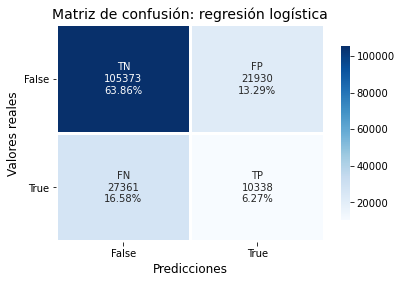

In [27]:
# Selección de variables definitivas
lr_train, lr_val, lr_test = scale_inputs(X_train[get_features(X_train.columns, lr_best_features)],
                                         X_val[get_features(X_val.columns, lr_best_features)], 
                                         X_test[get_features(X_test.columns, lr_best_features)])

# Se genera el nuevo modelo
lr_model = LogisticRegression(random_state=22, 
                              class_weight='balanced', 
                              solver=lr_best_params.get('solver'),
                              C=lr_best_params.get('C'), 
                              max_iter=lr_best_params.get('max_iter'),
                              penalty=lr_best_params.get('penalty'))

# Se entrena y registra el tiempo de entrenamiento
start = timer()
lr_model.fit(lr_train, y_train)
end = timer()
exec_time = end - start

# Se realiza la predicción sobre el conjunto de validación
lr_y_pred = lr_model.predict(lr_val)

# Generación de la matriz de confusión y del informe de métricas
lr_conf_matrix = metrics.confusion_matrix(y_val, lr_y_pred)
lr_class_metrics = metrics.classification_report(y_val, lr_y_pred, output_dict=True, zero_division=0)   

print(metrics.classification_report(y_val, lr_y_pred, output_dict=False, zero_division=0))
conf_matrix_plot(lr_conf_matrix, 'Matriz de confusión: regresión logística', labels).show()

# Se almacena el resultado obtenido para su comparación posterior con otros algoritmos
summary.append(('Regresión logística', 
                lr_best_params,
                lr_best_features,
                exec_time,
                lr_class_metrics.get('macro avg').get('f1-score'),
                lr_class_metrics.get('macro avg').get('precision'),
                lr_class_metrics.get('macro avg').get('recall'),
                lr_class_metrics.get('True').get('f1-score'),
                lr_class_metrics.get('True').get('precision'),
                lr_class_metrics.get('False').get('f1-score'),
                lr_class_metrics.get('False').get('precision')))

A pesar del ajuste de hiperparámetros, las métricas obtenidas por el modelo son muy parecidas a las obtenidas en el modelo base. El *F1 score* se sitúa en el 56% y aunque la exactitud (*accuracy*) total es del 70%, hay que tener en cuenta que la precisión obtenida en la clase positiva es muy baja.   
En la matriz de confusión se muestra el número de observaciones y su porcentaje sobre el total para cada tipo de resultado de la clasificación: verdaderos negativos, falsos positivos, falsos negativos y verdaderos positivos.

### 3.2 Árbol de decisión

En segundo lugar se emplea un árbol de decisión, cuyas principales ventajas son su fácil interpretación y que puede gestionar características no lineales e interacciones existentes entre variables.

In [28]:
# Variables para almacenar la mejor configuración
tree_best_features = []
tree_best_params = []
tree_best_score = .0

# Hiperparámetros a probar
params = {'splitter': ['best', 'random'], 
          'criterion': ['gini', 'entropy'],
          'max_depth': [5, 15, 20, 30, None],
          'min_samples_leaf': [1, 5, 9],
          'min_impurity_decrease': [0, 0.01, 0.1, 0.25],
          'max_features': ['sqrt', 'log2']}

# Se busca la mejor combinación de atributos e hiperparámetros con validación cruzada
for features in best_features:
    # Selección de variables
    tree_train = X_train[get_features(X_train.columns, features)]
    tree_val = X_val[get_features(X_val.columns, features)]

    # Definición del modelo
    tree_model = DecisionTreeClassifier(random_state=seed, class_weight='balanced')

    # Grid con cross validation
    tree_grid = GridSearchCV(tree_model, params, scoring='f1_macro', cv=tscv)
    tree_grid.fit(tree_train, y_train)

    # Se muestra la combinación de hiperparámetros con mejor rendimiento
    print('\nVariables:', features)
    print('Hiperparámetros con mejores resultados:', tree_grid.best_params_)
    print('Puntuación media del mejor estimador: %.6f' % tree_grid.best_score_)
    
    # En cada iteración se comprueba si el resultado obtenido es mejor
    if tree_grid.best_score_ > tree_best_score:
        tree_best_score = tree_grid.best_score_
        tree_best_features = features
        tree_best_params = tree_grid.best_params_


Variables: ['Type', 'Officer-ethnicity', 'Income', 'Year']
Hiperparámetros con mejores resultados: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_impurity_decrease': 0, 'min_samples_leaf': 5, 'splitter': 'best'}
Puntuación media del mejor estimador: 0.555771

Variables: ['Type', 'Officer-ethnicity', 'Income', 'Year', 'Same-ethnicity']
Hiperparámetros con mejores resultados: {'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'min_impurity_decrease': 0, 'min_samples_leaf': 5, 'splitter': 'random'}
Puntuación media del mejor estimador: 0.549102

Variables: ['Type', 'Officer-ethnicity', 'Income', 'Year', 'Weekend']
Hiperparámetros con mejores resultados: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_impurity_decrease': 0, 'min_samples_leaf': 9, 'splitter': 'best'}
Puntuación media del mejor estimador: 0.550142


              precision    recall  f1-score   support

       False       0.80      0.82      0.81    127303
        True       0.32      0.30      0.31     37699

    accuracy                           0.70    165002
   macro avg       0.56      0.56      0.56    165002
weighted avg       0.69      0.70      0.69    165002



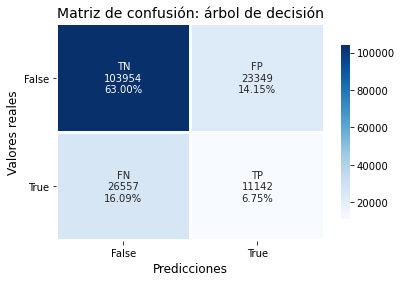

In [29]:
# Selección de variables definitivas
tree_train = X_train[get_features(X_train.columns, tree_best_features)]
tree_val = X_val[get_features(X_val.columns, tree_best_features)]
tree_test = X_test[get_features(X_test.columns, tree_best_features)]

# Se entrena el modelo y se evalúa con el conjunto de validación
tree_model = DecisionTreeClassifier(random_state=seed, 
                                    class_weight='balanced', 
                                    splitter=tree_best_params.get('splitter'),
                                    criterion=tree_best_params.get('criterion'),
                                    max_depth=tree_best_params.get('max_depth'),
                                    min_samples_leaf=tree_best_params.get('min_samples_leaf'),
                                    min_impurity_decrease=tree_best_params.get('min_impurity_decrease'), 
                                    max_features=tree_best_params.get('max_features'))

# Recogida del tiempo de entrenamiento
start = timer()
tree_model.fit(tree_train, y_train)
end = timer()
exec_time = end - start

# Predicción para el conjunto de validación
tree_y_pred = tree_model.predict(tree_val)

# Generación de la matriz de confusión y del informe de métricas
tree_conf_matrix = metrics.confusion_matrix(y_val, tree_y_pred)
tree_class_metrics = metrics.classification_report(y_val, tree_y_pred, output_dict=True, zero_division=0)   

print(metrics.classification_report(y_val, tree_y_pred, output_dict=False, zero_division=0))
conf_matrix_plot(tree_conf_matrix, 'Matriz de confusión: árbol de decisión', labels).show()

summary.append(('Árbol de decisión', 
                tree_best_params,
                tree_best_features,
                exec_time,
                tree_class_metrics.get('macro avg').get('f1-score'), 
                tree_class_metrics.get('macro avg').get('precision'), 
                tree_class_metrics.get('macro avg').get('recall'),
                tree_class_metrics.get('True').get('f1-score'), 
                tree_class_metrics.get('True').get('precision'),
                tree_class_metrics.get('False').get('f1-score'), 
                tree_class_metrics.get('False').get('precision')))

Los resultados con el árbol de decisión mejoran ligeramente los obtenidos con la regresión lineal. El *F1 score* se mantiene en un 56% y la precisión de la clase positiva en el 32%. En la matriz de confusión puede observarse el alto porcentaje sobre el total de registros de falsos positivos y falsos negativos en los que incurre el modelo.

### 3.3 Random forest

El siguiente algoritmo seleccionado es el *random forest*, que es más robusto que los árboles de decisión, menos propenso al sobreajuste y suele obtener menos errores de clasificación.

In [30]:
# Variables para almacenar la mejor configuración
rf_best_features = []
rf_best_params = []
rf_best_score = .0

# Hiperparámetros a probar
params = {'n_estimators': [10, 25, 50],
          'criterion': ['gini', 'entropy'],
          'max_depth': [5, 10, 20, None],
          'min_samples_leaf': [1, 5, 10],
          'max_features': ['sqrt', 'log2']}

# Se busca la mejor combinación de atributos e hiperparámetros
for features in best_features:
    # Selección de variables
    rf_train = X_train[get_features(X_train.columns, features)]
    rf_val = X_val[get_features(X_val.columns, features)]

    # Modelo base
    rf_model = RandomForestClassifier(random_state=seed, class_weight='balanced')

    # Grid con cross validation para probar las distintas combinaciones de hiperparámetros
    rf_grid = GridSearchCV(rf_model, params, scoring='f1_macro', cv=tscv)
    rf_grid.fit(rf_train, y_train)

    # Se muestra la combinación de hiperparámetros con mejor rendimiento y
    # la precisión media obtenida con cross validation
    print('\nVariables:', features)
    print('Hiperparámetros con mejores resultados:', rf_grid.best_params_)
    print('Puntuación media del mejor estimador: %.6f' % rf_grid.best_score_)

    # En cada iteración se revisa si el resultado obtenido mejora los anteriores
    if rf_grid.best_score_ > rf_best_score:
        rf_best_score = rf_grid.best_score_
        rf_best_features = features
        rf_best_params = rf_grid.best_params_


Variables: ['Type', 'Officer-ethnicity', 'Income', 'Year']
Hiperparámetros con mejores resultados: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 50}
Puntuación media del mejor estimador: 0.554639

Variables: ['Type', 'Officer-ethnicity', 'Income', 'Year', 'Same-ethnicity']
Hiperparámetros con mejores resultados: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 10}
Puntuación media del mejor estimador: 0.553577

Variables: ['Type', 'Officer-ethnicity', 'Income', 'Year', 'Weekend']
Hiperparámetros con mejores resultados: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 10}
Puntuación media del mejor estimador: 0.553234


              precision    recall  f1-score   support

       False       0.80      0.80      0.80    127303
        True       0.32      0.32      0.32     37699

    accuracy                           0.69    165002
   macro avg       0.56      0.56      0.56    165002
weighted avg       0.69      0.69      0.69    165002



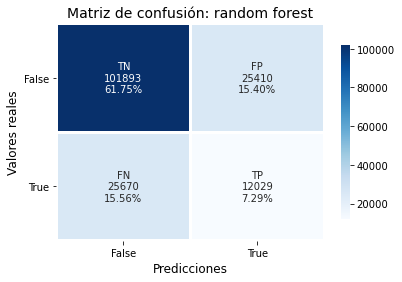

In [31]:
# Selección definitiva de variables
rf_train = X_train[get_features(X_train.columns, rf_best_features)]
rf_val = X_val[get_features(X_val.columns, rf_best_features)]
rf_test = X_test[get_features(X_test.columns, rf_best_features)]

# Se entrena el modelo y se evalúa con el conjunto de validación
rf_model = RandomForestClassifier(random_state=seed, 
                                  class_weight='balanced', 
                                  n_estimators=rf_best_params.get('n_estimators'),
                                  criterion=rf_best_params.get('criterion'),
                                  max_depth=rf_best_params.get('max_depth'),
                                  min_samples_leaf=rf_best_params.get('min_samples_leaf'),
                                  max_features=rf_best_params.get('max_features'))

# Entrenamiento del modelo y toma de tiempos
start = timer()
rf_model.fit(rf_train, y_train)
end = timer()
exec_time = end - start

# Realización de predicciones sobre el conjunto de validación
rf_y_pred = rf_model.predict(rf_val)

# Generación de la matriz de confusión y del informe de métricas
rf_conf_matrix = metrics.confusion_matrix(y_val, rf_y_pred)
rf_class_metrics = metrics.classification_report(y_val, rf_y_pred, output_dict=True, zero_division=0)   

print(metrics.classification_report(y_val, rf_y_pred, output_dict=False, zero_division=0))
conf_matrix_plot(rf_conf_matrix, 'Matriz de confusión: random forest', labels).show()

summary.append(('Random forest',
                rf_best_params,
                rf_best_features,
                exec_time,
                rf_class_metrics.get('macro avg').get('f1-score'), 
                rf_class_metrics.get('macro avg').get('precision'), 
                rf_class_metrics.get('macro avg').get('recall'),
                rf_class_metrics.get('True').get('f1-score'), 
                rf_class_metrics.get('True').get('precision'),
                rf_class_metrics.get('False').get('f1-score'), 
                rf_class_metrics.get('False').get('precision')))

Como puede observarse, los resultados son muy parecidos a los ya obtenidos por el árbol de decisión, no consiguiendo mejorar los números de falsos positivos ni falsos negativos. Se percibe una mejora en los verdaderos positivos respecto a los modelos anteriores.

### 3.4 Light GBM

Por último, se emplea el algoritmo *Light GBM*, más rápido de entrenar y que requiere menos memoria que XGBoost y que suele conseguir mejor exactitud que otros algoritmos de *boosting*.

In [32]:
# Variables para almacenar la mejor configuración
lg_best_features = []
lg_best_params = []
lg_best_score = .0

# Hiperparámetros a probar
params = {'n_estimators': [10, 50, 100],
          'learning_rate': [0.001, 0.01, 0.1, 1],
          'max_depth': [5, 10, 20],
          'num_leaves': [5, 10, 20, 30]}

# Se busca la mejor combinación de atributos e hiperparámetros con validación cruzada
for features in best_features:
    # Selección de variables
    lg_train = X_train[get_features(X_train.columns, features)]
    lg_val = X_val[get_features(X_val.columns, features)]
    
    # Modelo base sobre el que se aplican los hiperparámetros
    lg_model = LGBMClassifier(random_state=seed, class_weight='balanced', application='binary')

    # Grid con cross validation para probar las distintas combinaciones de hiperparámetros
    lg_grid = GridSearchCV(lg_model, params, scoring='f1_macro', cv=tscv)
    lg_grid.fit(lg_train, y_train)

    # Se muestra la combinación de hiperparámetros con mejor rendimiento y
    # la precisión media obtenida con cross validation
    print('\nVariables:', features)
    print('Hiperparámetros con mejores resultados:', lg_grid.best_params_)
    print('Puntuación media del mejor estimador: %.6f' % lg_grid.best_score_)
    
    # En cada iteración se comprueba si el resultado obtenido es mejor
    if lg_grid.best_score_ > lg_best_score:
        lg_best_score = lg_grid.best_score_
        lg_best_features = features
        lg_best_params = lg_grid.best_params_


Variables: ['Type', 'Officer-ethnicity', 'Income', 'Year']
Hiperparámetros con mejores resultados: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'num_leaves': 10}
Puntuación media del mejor estimador: 0.554574

Variables: ['Type', 'Officer-ethnicity', 'Income', 'Year', 'Same-ethnicity']
Hiperparámetros con mejores resultados: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'num_leaves': 30}
Puntuación media del mejor estimador: 0.554596

Variables: ['Type', 'Officer-ethnicity', 'Income', 'Year', 'Weekend']
Hiperparámetros con mejores resultados: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100, 'num_leaves': 20}
Puntuación media del mejor estimador: 0.554433


              precision    recall  f1-score   support

       False       0.80      0.79      0.79    127303
        True       0.32      0.33      0.32     37699

    accuracy                           0.69    165002
   macro avg       0.56      0.56      0.56    165002
weighted avg       0.69      0.69      0.69    165002



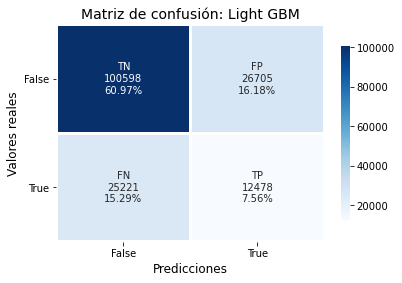

In [33]:
# Selección de variables definitivas
lg_train = X_train[get_features(X_train.columns, lg_best_features)]
lg_val = X_val[get_features(X_val.columns, lg_best_features)]
lg_test = X_test[get_features(X_test.columns, lg_best_features)]

# Se entrena el modelo y se evalúa con el conjunto de validación
lg_model = LGBMClassifier(random_state=seed, 
                          class_weight='balanced',
                          application='binary',
                          max_depth=lg_best_params.get('max_depth'),
                          n_estimators=lg_best_params.get('n_estimators'),
                          learning_rate=lg_best_params.get('learning_rate'),
                          num_leaves=lg_best_params.get('num_leaves'))

# Entrenamiento del modelo y toma de tiempos
start = timer()
lg_model.fit(lg_train, y_train)
end = timer()
exec_time = end - start

# Realización de predicciones sobre el conjunto de validación
lg_y_pred = lg_model.predict(lg_val)

# Generación de la matriz de confusión y del informe de métricas
lg_conf_matrix = metrics.confusion_matrix(y_val, lg_y_pred)
lg_class_metrics = metrics.classification_report(y_val, lg_y_pred, output_dict=True, zero_division=0)

print(metrics.classification_report(y_val, lg_y_pred, output_dict=False, zero_division=0))
conf_matrix_plot(lg_conf_matrix, 'Matriz de confusión: Light GBM', labels).show()

summary.append(('Light GBM',
                lg_best_params,
                lg_best_features,
                exec_time,
                lg_class_metrics.get('macro avg').get('f1-score'), 
                lg_class_metrics.get('macro avg').get('precision'), 
                lg_class_metrics.get('macro avg').get('recall'),
                lg_class_metrics.get('True').get('f1-score'), 
                lg_class_metrics.get('True').get('precision'),
                lg_class_metrics.get('False').get('f1-score'), 
                lg_class_metrics.get('False').get('precision')))

El desempeño obtenido es, de nuevo, muy parecido al obtenido con el resto de algoritmos, con una precisión alta en la clase negativa pero muy baja en la positiva. La métrica que se ha tomado como principal referencia para la evaluación de los modelos, el *F1 score* 'macro average', es 0.56, estando en los mismos niveles que el resto de algoritmos.

## 4. Selección del modelo

A continuación se muestra el resumen de las mejores configuraciones de los cuatro modelos construidos, ordenados por *F1 score* global, *F1 score* de la clase positiva y tiempo de entrenamiento.

In [34]:
# Se muestran los resultados de todas las pruebas ordenados por F1 score y tiempo de entrenamiento
df_summary = pd.DataFrame(summary, columns=('Algoritmo', 'Hiperparámetros', 'Características', 'Tiempo de entrenamiento', 
                                            'F1 conjunto', 'Precisión conjunta', 'Recall conjunto', 'F1 clase pos.', 
                                            'Precisión clase pos.', 'F1 clase neg.', 'Precisión clase neg.'))
df_summary = df_summary.sort_values(by=['F1 conjunto', 'F1 clase pos.', 'Tiempo de entrenamiento'], 
                                    ascending=False, ignore_index=True)
df_summary.head()

,Algoritmo,Hiperparámetros,Características,Tiempo de entrenamiento,F1 conjunto,Precisión conjunta,Recall conjunto,F1 clase pos.,Precisión clase pos.,F1 clase neg.,Precisión clase neg.
0,Random forest,"{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 50}","[Type, Officer-ethnicity, Income, Year]",5.0876,0.5599,0.5600,0.5597,0.3202,0.3213,0.7996,0.7988
1,Light GBM,"{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'num_leaves': 30}","[Type, Officer-ethnicity, Income, Year, Same-ethnicity]",1.3910,0.5597,0.5590,0.5606,0.3246,0.3185,0.7949,0.7995
2,Árbol de decisión,"{'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_impurity_decrease': 0, 'min_samples_leaf': 5, 'splitter': 'best'}","[Type, Officer-ethnicity, Income, Year]",0.1441,0.5576,0.5598,0.5561,0.3087,0.3230,0.8064,0.7965
3,Regresión logística,"{'C': 0.001, 'max_iter': 200, 'penalty': 'l2', 'solver': 'newton-cg'}","[Type, Officer-ethnicity, Income, Year]",1.6952,0.5530,0.5571,0.5510,0.2955,0.3204,0.8104,0.7939


Aunque las diferencias son mínimas entre los algoritmos probados, con un *F1 score* muy parecido en todos los casos, se escoge como modelo final el *random forest*, pues que ha obtenido unos resultados ligeramente mejores al resto. Aunque su tiempo de entrenamiento es el mayor de todos los modelos probados, no es tan elevado como para plantearse la elección de otro algoritmo.    
Los *random forest* no son tan fáciles de interpretar como las regresiones logísticas o los árboles de decisión. En estos últimos puede mostrarse la estructura del árbol obtenido y analizar visualmente las decisiones tomadas por el modelo. Pero en un *random forest* se generan varios árboles de decisión, lo que dificulta estudiar el comportamiento del modelo de forma visual. Aunque pueden mostrarse algunos de los árboles a modo ilustrativo, es complicado mostrar todos (sobre todo en este caso, donde se han empleado 50 estimadores) e interpretarlos en su conjunto.    

In [41]:
# Se selecciona el modelo con el mejor desempeño
algorithm = df_summary.iloc[0]['Algoritmo']

if algorithm == 'Regresión logística':
    best_model = lr_model
    bm_train = lr_train
    bm_val = lr_val
    bm_test = lr_test
    
elif algorithm == 'Árbol de decisión':
    best_model = tree_model
    bm_train = tree_train
    bm_val = tree_val
    bm_test = tree_test
    
elif algorithm == 'Random forest':
    best_model = rf_model
    bm_train = rf_train
    bm_val = rf_val
    bm_test = rf_test
    
else:
    best_model = lg_model
    bm_train = lg_train
    bm_val = lg_val
    bm_test = lg_test

# Se recoge el conjunto de variables usado por el modelo, incorporando el distrito en caso de que no
# fuese una de las características escogidas para su uso en el estudio de equidad posterior
sel_cols = df_summary.iloc[0]['Características'] + [target]
sel_data = sel_data[sel_cols]
if 'Borough' not in sel_cols:
    sel_data['Borough'] = london_data['Borough']    

Se vuelcan a fichero el modelo, el dataset escogido y los diferentes conjuntos de datos generados para su uso en posteriores *notebooks*. En concreto, esta información es recuperada para aplicar varias técnicas de explicabilidad sobre el modelo y revisar su equidad.

In [44]:
# Se escriben a fichero los conjuntos de datos y el modelo para usarlos en otro notebook   
pickle.dump(best_model, open('model.sav', 'wb'))
pickle.dump(sel_data, open('sel_data.sav', 'wb'))
pickle.dump(bm_train, open('x_train.sav', 'wb'))
pickle.dump(y_train, open('y_train.sav', 'wb'))
pickle.dump(bm_val, open('x_val.sav', 'wb'))
pickle.dump(y_val, open('y_val.sav', 'wb'))
pickle.dump(bm_test, open('x_test.sav', 'wb'))
pickle.dump(y_test, open('y_test.sav', 'wb'))

A continuación se utiliza el modelo seleccionado sobre el conjunto de test y se obtienen sus métricas, observando un rendimiento muy parecido al ya obtenido en el conjunto de validación.

              precision    recall  f1-score   support

       False       0.79      0.77      0.78    180168
        True       0.32      0.35      0.33     55549

    accuracy                           0.67    235717
   macro avg       0.56      0.56      0.56    235717
weighted avg       0.68      0.67      0.68    235717



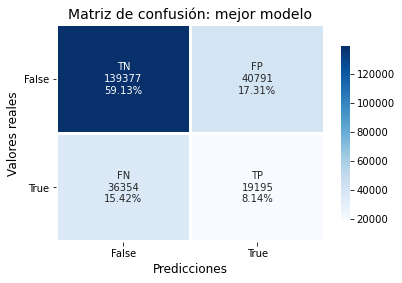

In [45]:
# Predicción sobre el conjunto de test
bm_y_pred = best_model.predict(bm_test)

# Generación de la matriz de confusión y del informe de métricas
bm_conf_matrix = metrics.confusion_matrix(y_test, bm_y_pred)
print(metrics.classification_report(y_test, bm_y_pred, output_dict=False, zero_division=0))
conf_matrix_plot(bm_conf_matrix, 'Matriz de confusión: mejor modelo', labels).show()

Por último, se muestran los histogramas de las probabilidades obtenidas por el modelo para la clase positiva en las actuaciones positivas y en las negativas.

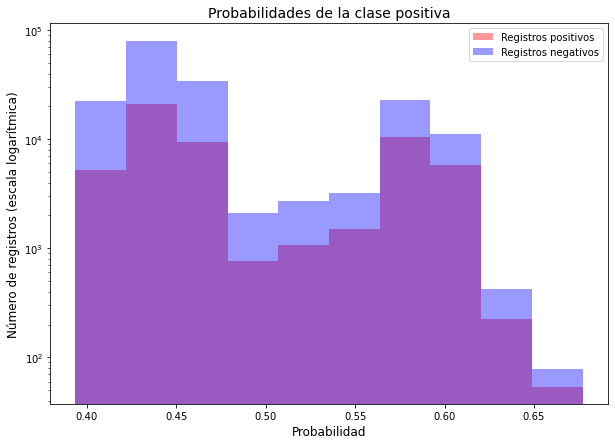

In [46]:
# Se recogen las probabilidades calculadas por el modelo para la clase positiva en cada 
# registro del conjunto de test
probs_class_true = best_model.predict_proba(bm_test)[:,1]

# Selección de las predicciones de la clase positiva para los registros con Further-action=True
probs_fa_true = probs_class_true[(y_test==True)]

# Selección de las predicciones de la clase positiva para los registros con Further-action=False
probs_fa_false = probs_class_true[(y_test==False)]

# Histograma con las probabilidades para la clase positiva 
plt.figure(figsize=(10,7))
plt.hist(probs_fa_true, label='Registros positivos', alpha=0.4, color='red', log=True)
plt.hist(probs_fa_false, label='Registros negativos', alpha=0.4, color='blue', log=True)
plt.title('Probabilidades de la clase positiva', fontsize=14)
plt.xlabel('Probabilidad', fontsize=12)
plt.ylabel('Número de registros (escala logarítmica)', fontsize=12)
plt.legend()
plt.show()

En la gráfica la mayoría de observaciones se concentra en la franja de probabilidad de 0.4 y 0.6, mostrando la dificultad del modelo para realizar la clasificación. Además, ambos histogramas presentan una distribución similar, lo que demuestra que el modelo no encuentra una distinción clara entre los registros de una clase y otra.